# Feature Engineering

This notebook will engineer text features from the property reviews, and temporal features from calendar data.  The text features will include the top BOW words from the preprocessed text, and cluster labels after text embedding.  (May need extra computing power).  The temporal features will be aggregated features like average price of neighbourhood by month.

In [10]:
# Read in libraries
# Load libraries
import numpy as np
import pandas as pd
import time
import os
import sys
import ast
import json
import datetime as dt
from datetime import datetime
from itertools import chain
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import manifold
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# Unlimited columns
pd.options.display.max_columns = None

In [3]:
# Read in data
# Load calendar data
calendar = pd.read_csv("../data/processed/calendar.csv")

# Load reviews data
review_map = pd.read_csv("../data/raw/reviews_ids.csv")
reviews = pd.read_csv("../data/processed/reviews.csv")

# Load listings data
listings = pd.read_csv("../data/processed/listings.csv")

# Load neighborhoods
neighborhoods = pd.read_csv("../data/processed/neighbourhoods.csv")

In [4]:
# Functions

## Review Feature Engineering

In [5]:
# BOW

In [6]:
reviews.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments
0,0,958,958,2009-07-23,958,Edmund C,experience without doubt five star experience ...
1,1,958,958,2009-08-03,958,Simon,returning san francisco rejuvenating thrill ti...
2,2,958,958,2009-09-27,958,Denis,pleased accommodations friendly neighborhood a...
3,3,958,958,2009-11-05,958,Anna,highly recommend accomodation agree previous p...
4,4,958,958,2010-02-13,958,Venetia,holly place great exactly needed perfect locat...


In [7]:
# Text Embedding
reviews['comments'] = reviews.comments.replace(np.nan, "")
corpus = list(reviews.comments)

In [8]:
vectorizer = TfidfVectorizer(stop_words={'english'})
vec_corpus = vectorizer.fit_transform(corpus)

In [12]:
Sum_of_squared_distances = []
K = range(3, 5)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(vec_corpus)
    Sum_of_squared_distances.append(km.inertia_)

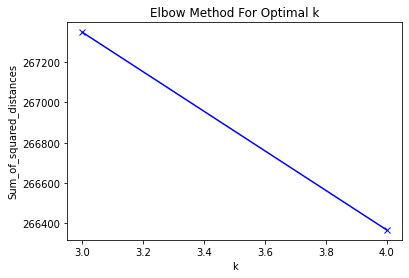

In [13]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Clustering

In [ ]:
# Add new features

## Calendar Feature Engineering

In [ ]:
# Merge neighbourhood data onto calendar data

In [ ]:
# Add day of week feature

In [ ]:
# Add week of year feature

In [ ]:
# Add month of year feature

In [ ]:
# Add year feature

In [ ]:
# Add binary holiday feature

In [ ]:
# Aggregate price by day, week, month, year and neighborhood